# Bangkit Assigment: Lung Disease Classification with Machine Learning
This is an initial commit of the notebook, please add more things here!

## Importing Data from Kaggle

In [0]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [2]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset from upstream
!kaggle datasets download -d vbookshelf/respiratory-sound-database

100% 3.67G/3.69G [00:45<00:00, 74.9MB/s]
100% 3.69G/3.69G [00:45<00:00, 87.0MB/s]


In [5]:
# Unzip dataset into a folder
!unzip respiratory-sound-database.zip -d dataset
!rm respiratory-sound-database.zip

Archive:  respiratory-sound-database.zip
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_fi

## Data Preparation

In [0]:
# Import necessary libraries for processing
import wave
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [0]:
df_no_diagnosis = pd.read_csv('dataset/demographic_info.txt', names = 
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [8]:
# Combine diagnosis data with patient data
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

In [0]:
root = 'dataset/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

In [0]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [11]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,174,2p3,Pl,mc,AKGC417L
0,185,1b1,Ar,sc,Litt3200
0,203,1p4,Pl,mc,AKGC417L
0,147,2b3,Al,mc,AKGC417L
0,163,2b2,Pr,mc,AKGC417L


In [0]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})

In [13]:
w_labels = file_label_df[(file_label_df['crackles only'] != 0) | (file_label_df['wheezes only'] != 0) | (file_label_df['crackles and wheezees'] != 0)]
file_label_df.sum()

filename                 174_2p3_Pl_mc_AKGC417L185_1b1_Ar_sc_Litt320020...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

## Utility Functions

In [0]:
import math
import scipy.io.wavfile as wf
#wave file reader

#Will resample all files to the target sample rate and produce a 32bit float array
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return (target_rate, data.astype(np.float32))

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

## Distribution of respiratory cycle lengths


longest cycle:16.163
shortest cycle:0.20000000000000284
Fraction of samples less than 5 seconds:0.9660771238040011


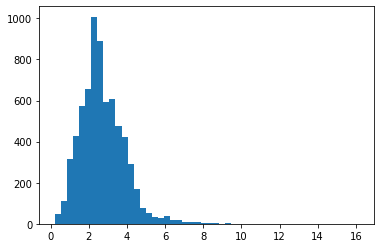

In [15]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{}'.format(max(duration_list)))
print('shortest cycle:{}'.format(min(duration_list)))
threshold = 5
print('Fraction of samples less than {} seconds:{}'.format(threshold,
                                                           np.sum(duration_list < threshold)/len(duration_list)))

### Feature Extraction



In [0]:
max_pad_len = 862 # to make the length of all MFCC equal

#This function takes in the path for an audio file as a string, loads it, and returns the MFCC
# of the audio
def extract_features_mfcc(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [17]:
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

filenames = [f for f in listdir(root) if (isfile(join(root, f)) and f.endswith('.wav'))] 

filepaths = [join(root, f) for f in filenames] # full paths of files

features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features_mfcc(file_name)
    print(data)
    features.append(data)

print('Finished feature extraction using MFCC from ', len(features), ' files')

Streaming output truncated to the last 5000 lines.
 [   0.            0.            0.         ...   -2.11446295
     4.00958326    4.1097927 ]
 [   0.            0.            0.         ...   -2.23049273
    -0.64967319    1.80630098]
 [   0.            0.            0.         ...   -1.80400987
    -1.55969869    4.60058952]]
[[-525.87779245 -545.16637799 -565.33420006 ... -598.00993018
  -601.75574766 -601.74884486]
 [  71.5834248    96.12691843  110.44896287 ...   83.3425639
    79.04722771   76.37456979]
 [  73.0095259    58.05780189   52.62703649 ...   59.89458494
    55.84736527   52.5699497 ]
 ...
 [   8.99619839    7.10464149    2.36882058 ...    3.75231198
     4.16338139    2.16871593]
 [   7.34879652    4.62371231    3.51399939 ...    5.5629445
     5.58686246    4.01255338]
 [   3.04919427    3.63480259    5.23886201 ...    4.92585875
     4.83361407    4.73352159]]
[[-4.37250743e+02 -4.37250743e+02 -4.37250743e+02 ... -3.28637953e+02
  -3.46089612e+02 -3.60538027e+02]
 [

In [18]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# patient IDs corresponding to each file
p_id_in_file = [] 
for name in filenames:
    p_id_in_file.append(int(name[:3]))

# patient diagnosis file - Should use the file in the beginning of the notebook but it returns error
p_diag = pd.read_csv('dataset/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',header=None) 

p_id_in_file = np.array(p_id_in_file) 

# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) 

# Remove a very rare disease, it returns an error if we're not removing it
labels_fix = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels_fix)
oh_labels = to_categorical(i_labels) 


Using TensorFlow backend.


In [0]:
# convert to numpy array
features = np.array(features) 

# delete the very rare diseases
features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 

# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

In [0]:
from sklearn.model_selection import train_test_split

# train test split = This is the data for training the model
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

### Build the Model Using CNN
